# This notebook analyse monsoon domain. The structure of this notebook is similar to ensemble(mean)_TempPrecip(change)_more_options. See there for detailed documentation

In [1]:
'''Import packages for loading data, analysing, and plotting'''
# This cell imports the necessary packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import os
import matplotlib.colors as colors


In [2]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               




In [3]:
#No change needs here

'''Define calculating functions, same as in Ensemble one with slight changes applied to fit monsoon calculations'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="DATA/%s" %(experiment_name)
    ensemble_members=!../bin/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    


In [18]:
#This function claculates monsoon domains
#summer rainrate - winter rainrate > 2.0
#summer rainrate/annual rainrate > 0.55
def monsoon_mean(pmip_v,expt):
    experiment_name=expt
    variable_name='monsoon_intensity' #summer rainrate - winter rainrate
    summerrain='monsoon_summer_rainrate'
    annualrain='pr_spatialmean_ann' #annual rainrate
    model_list=[]
    n=0
    
    average=0
    avesummer=0
    aveann=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            model_list.append(gcm)
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            ir=this_file[variable_name]
            sr=this_file[summerrain]
            ar=this_file[annualrain]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
            ir_1x1=this_regridder(ir)
            sr_1x1=this_regridder(sr)
            ar_1x1=this_regridder(ar)
            average=(n*average+ir_1x1)/(n+1)
            avesummer=(n*avesummer+sr_1x1)/(n+1)
            aveann=(n*aveann+ar_1x1)/(n+1)
            n=n+1
    ratio=avesummer/aveann
    m1=average >2.0
    m2=ratio >0.55
    mask=np.all([m1,m2],axis=0)
    aaa=avesummer.where(mask)
    return aaa

#This function defind the boundary of present monsoon domians from observation
def domain_obs():
    obs_file=xr.open_dataset('DATA/C20-Reanalysis.cvdp_data.1871-2012.nc',decode_times=False)
    domain=obs_file['monsoon_domain']
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                             'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    this_regridder=xe.Regridder(obs_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
    obs_domain=this_regridder(domain)
    domain_r=np.array(obs_domain)
    ax=pd.DataFrame(domain_r)
    DO=np.array(ax.fillna(3000))
    return DO

In [11]:
#This function claculates monsoon domains for individual models
#summer rainrate - winter rainrate > 2.0
#summer rainrate/annual rainrate > 0.55
def monsoon_model(pmip_v,expt):
    filename='%s_models_monsoon_domain_1.nc'%expt
    d=Dataset(filename,'a')
    experiment_name=expt
    variable_name='monsoon_intensity' #summer rainrate - winter rainrate
    summerrain='monsoon_summer_rainrate'
    annualrain='pr_spatialmean_ann' #annual rainrate
    model_list=[]
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            model_list.append(gcm)
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            ir=this_file[variable_name]
            sr=this_file[summerrain]
            ar=this_file[annualrain]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
            ir_1x1=this_regridder(ir)
            sr_1x1=this_regridder(sr)
            ar_1x1=this_regridder(ar)
            ratio=sr_1x1/ar_1x1
            m1=ir_1x1>2.0
            m2=ratio>0.55
            mask=np.all([m1,m2],axis=0)
            aaa=sr_1x1.where(mask)
            d.createVariable(gcm,'f',("lat",'lon'))  
            d.variables[gcm][:]=aaa
    d.close()




In [11]:
monsoon_model('PMIP4','piControl')

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_120x180_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc


In [12]:
monsoon_model('PMIP4','midHolocene')

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_80x180_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_120x180_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc


In [12]:
#This function defind the boundary of midHolocene monsoon domians
def monsoon_mean_boundary(GMD_mh):
    d=np.array(GMD_mh)
    df=pd.DataFrame(d)
    ccc=np.array(df.fillna(3000))
    return ccc

#This functions calculates the changes in monsoon intensity and summer rainrate (midHolocene - piControl)
def monsoon_mean_diffence(pmip_v,variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,'midHolocene')
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    return average

In [13]:
'''Define plotting function'''

y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)


def domian_plot(data,experiment_name):
    cmap=plt.get_cmap('GnBu')
    bounds = np.linspace(2, 16, 8)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='%s' %(experiment_name)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data,levels=bounds, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    
    ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    
def domain_diff_plot(data,variable):
    cmap=plt.get_cmap('BrBG')
    clim=[-3,3]
    bounds = np.linspace(-3, 3, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='%s %s'%(chr(916),variable)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-8,vmax=8)
    fig.set_clim(-6,6)
    #ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    ax.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
    ax.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    

# Calculations


In [16]:

GMD_pi=monsoon_mean('PMIP4','piControl')
GMD_mh=monsoon_mean('PMIP4','midHolocene') 


/Users/annie/anaconda3/envs/plot/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [19]:
DO=domain_obs()

In [20]:
b_mh=monsoon_mean_boundary(GMD_mh)
b_pi=monsoon_mean_boundary(GMD_pi)

In [23]:

sdiff=monsoon_mean_diffence('PMIP4','monsoon_summer_rainrate')
idiff=monsoon_mean_diffence('PMIP4','monsoon_intensity')

/Users/annie/anaconda3/envs/plot/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


# Plotting

<ipython-input-24-a186b4cbab02>:60: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
<ipython-input-24-a186b4cbab02>:62: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb1=plt.colorbar(fig1, cax=cax1, **kw1,extend='both')


<Figure size 1296x720 with 0 Axes>

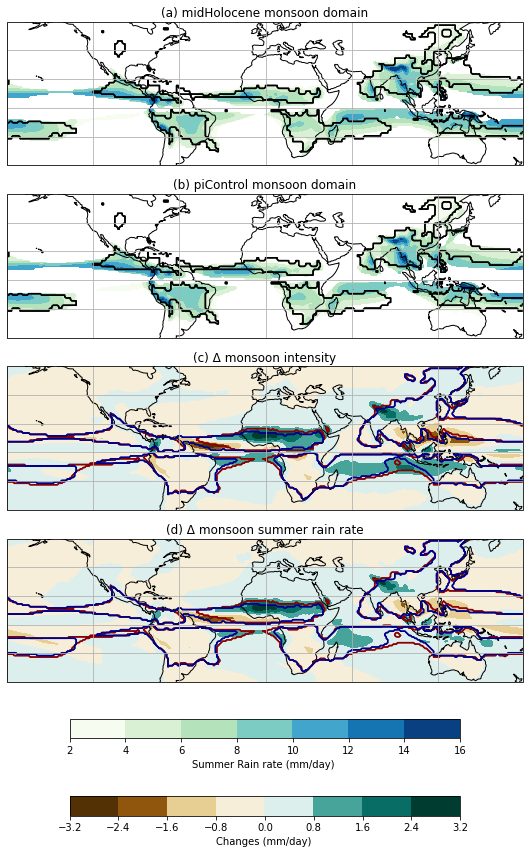

In [24]:
y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)



cmap1=plt.get_cmap('GnBu')
bounds1 = np.linspace(2, 16, 8)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
cmap2=plt.get_cmap('BrBG')
clim2=[-3,3]
bounds2 = np.linspace(-3, 3, 11)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)



plt.figure(figsize=(18,10))
fig, axs = plt.subplots(nrows=4,ncols=1,figsize=(10,15),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0, globe=None)})
ax1=axs[0]
ax2=axs[1]
ax3=axs[2]
ax4=axs[3]

# MH monsoon domain
ax1.set_title('(a) midHolocene monsoon domain',pad=5)
ax1.set_ylim([-40,60])
ax1.coastlines()
ax1.gridlines()
fig1=ax1.contourf(x,y,GMD_mh,levels=bounds1, transform=ccrs.PlateCarree(),cmap=cmap1,norm=norm1)
ax1.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')

# PI monsoon domain
ax2.set_title('(b) piControl monsoon domain',pad=5)
ax2.set_ylim([-40,60])
ax2.coastlines()
ax2.gridlines()
fig2=ax2.contourf(x,y,GMD_pi,levels=bounds1, transform=ccrs.PlateCarree(),cmap=cmap1,norm=norm1)
ax2.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')

# change in monsoon intensity
ax3.set_title('(c) %s monsoon intensity'%(chr(916)),pad=5)
ax3.set_ylim([-40,60])
ax3.coastlines()
ax3.gridlines()
fig3=ax3.contourf(x,y,idiff, transform=ccrs.PlateCarree(),cmap=cmap2,norm=norm2)
ax3.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
ax3.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')



# change in monsoon summer rain rate
ax4.set_title('(d) %s monsoon summer rain rate'%(chr(916)),pad=5)
ax4.set_ylim([-40,60])
ax4.coastlines()
ax4.gridlines()
fig4=ax4.contourf(x,y,sdiff, transform=ccrs.PlateCarree(),cmap=cmap2,norm=norm2)
ax4.contour(x,y,b_mh, levels=[100,110], colors='darkred', linestyles='-')
ax4.contour(x,y,b_pi, levels=[100,110], colors='darkblue', linestyles='-')

cax2,kw2 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb2=plt.colorbar(fig4, cax=cax2, **kw2,extend='max')
cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.7,fraction=0.05)
cb1=plt.colorbar(fig1, cax=cax1, **kw1,extend='both')

cb1label='Summer Rain rate (mm/day) '
cb2label='Changes (mm/day) '
cb1.set_label(cb1label)
cb2.set_label(cb2label)
#plt.savefig('../plots/png/mh_monsoon_domain.png')
#plt.savefig('../plots/pdf/mh_monsoon_domain.pdf')

# Save 

In [11]:
# This cell saves the outputs above

filename='../outputs/netcdf/monsoon_domain.nc'
latS=np.arange(-89.5, 90., 1.0)
lonS=np.arange(-179.5, 180., 1.0)
d=Dataset(filename,'w',format='NETCDF4')
d.createDimension('lon',360)  
d.createDimension('lat',180)  
d.createVariable("lon",'f',("lon"))  
d.createVariable("lat",'f',("lat"))  

d.variables['lat'][:]=latS     
d.variables['lon'][:]=lonS 

d.createVariable('domain_mh','f',("lat",'lon'))  
d.variables['domain_mh'][:]=GMD_mh
d.createVariable('domain_pi','f',("lat",'lon'))  
d.variables['domain_pi'][:]=GMD_pi

d.createVariable('boundary_mh','f',("lat",'lon'))  
d.variables['boundary_mh'][:]=b_mh
d.createVariable('boundary_pi','f',("lat",'lon'))  
d.variables['boundary_pi'][:]=b_pi

d.createVariable('boundary_obs','f',("lat",'lon'))  
d.variables['boundary_obs'][:]=DO


d.createVariable('delta_intensity','f',("lat",'lon'))  
d.variables['delta_intensity'][:]=idiff
d.createVariable('delta_summer_rainrate','f',("lat",'lon'))  
d.variables['delta_summer_rainrate'][:]=sdiff



d.close()